In [47]:
import numpy as np
import gymnasium as gym
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [48]:
# Definir a rede neural QNetwork
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Camada fully connected 1
        self.fc2 = nn.Linear(64, 64)         # Camada fully connected 2
        self.fc3 = nn.Linear(64, output_dim) # Camada de saída

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Função de ativação ReLU
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Função para converter estados em tensores one-hot
def to_one_hot(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot)

# Função para extrair a política a partir da rede neural
def extract_policy(q_network, num_states):
    policy = []
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor)
        policy.append(torch.argmax(q_values).item())
    return policy

In [49]:
# Função para avaliar uma política no ambiente FrozenLake
def evaluate_policy_frozenlake(env, policy, episodes=100):
    total_rewards = []
    successes = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = policy[state]  # Ação escolhida pela política
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)
        if episode_reward > 0:  # Recompensa > 0 indica sucesso no FrozenLake
            successes += 1

    success_rate = (successes / episodes) * 100
    mean_return = np.mean(total_rewards)
    return success_rate, mean_return

In [50]:
def evaluate_policy_cliffwalking(env, policy, episodes=100, max_steps_per_episode=1000):
    total_rewards = []
    successes = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps_per_episode:
            action = policy[state]  # Ação escolhida pela política
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
            steps += 1

        total_rewards.append(episode_reward)
        if state == 47:  # Estado final do CliffWalking (destino)
            successes += 1

    success_rate = (successes / episodes) * 100
    mean_return = np.mean(total_rewards)
    return success_rate, mean_return

In [51]:
# Função para avaliar uma política no ambiente Taxi
def evaluate_policy_taxi(env, policy, episodes=100):
    total_rewards = []
    successes = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = policy[state]  # Ação escolhida pela política
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)
        if reward == 20:  # Recompensa máxima no Taxi (passageiro entregue)
            successes += 1

    success_rate = (successes / episodes) * 100
    mean_return = np.mean(total_rewards)
    return success_rate, mean_return

In [52]:
# Lista de ambientes e modelos a serem testados
environments = {
    "FrozenLake": "FrozenLake-v1",
    "Taxi": "Taxi-v3",
    "CliffWalking": "CliffWalking-v0"
    
}

models = {
    "FrozenLake": ["FQI_Greed_frozenLake.pth", "FQI_Sarsa_frozenLake.pth"],
    "Taxi": ["FQI_Greed_taxi.pth", "FQI_Sarsa_taxi.pth"],
    "CliffWalking": ["FQI_Greed_cliff.pth", "FQI_Sarsa_cliff.pth"]
    
}

# Dicionário para armazenar resultados
results = {env: {} for env in environments}

In [53]:
# Loop sobre os ambientes
for env_name, env_id in environments.items():
    print(f"\n=== Ambiente: {env_name} ===")
    env = gym.make(env_id, render_mode="rgb_array")
    input_dim = env.observation_space.n  # Número de estados
    output_dim = env.action_space.n      # Número de ações

    # Loop sobre os modelos do ambiente atual
    for model_name in models[env_name]:
        print(f"\nAvaliando o modelo: {model_name}...")
        model = QNetwork(input_dim, output_dim)
        model.load_state_dict(torch.load(f'model/{model_name}'))
        model.eval()

        # Extrair política
        policy = extract_policy(model, input_dim)

        # Avaliar política com a função correta para o ambiente
        start_time = time.time()
        if env_name == "FrozenLake":
            success_rate, mean_return = evaluate_policy_frozenlake(env, policy, episodes=1000)
        elif env_name == "CliffWalking":
            success_rate, mean_return = evaluate_policy_cliffwalking(env, policy, episodes=1000)
        elif env_name == "Taxi":
            success_rate, mean_return = evaluate_policy_taxi(env, policy, episodes=1000)
        eval_time = time.time() - start_time

        # Armazenar resultados
        results[env_name][model_name] = {
            "success_rate": success_rate,
            "mean_return": mean_return,
            "eval_time": eval_time
        }

        print(f"Taxa de Sucesso: {success_rate:.2f}%, Retorno Médio: {mean_return:.4f}, Tempo de Execução: {eval_time:.2f}s")


=== Ambiente: FrozenLake ===

Avaliando o modelo: FQI_Greed_frozenLake.pth...
Taxa de Sucesso: 15.70%, Retorno Médio: 0.1570, Tempo de Execução: 0.10s

Avaliando o modelo: FQI_Sarsa_frozenLake.pth...
Taxa de Sucesso: 23.90%, Retorno Médio: 0.2390, Tempo de Execução: 0.10s

=== Ambiente: Taxi ===

Avaliando o modelo: FQI_Greed_taxi.pth...
Taxa de Sucesso: 0.00%, Retorno Médio: -200.0000, Tempo de Execução: 1.28s

Avaliando o modelo: FQI_Sarsa_taxi.pth...
Taxa de Sucesso: 0.00%, Retorno Médio: -200.0000, Tempo de Execução: 1.43s

=== Ambiente: CliffWalking ===

Avaliando o modelo: FQI_Greed_cliff.pth...
Taxa de Sucesso: 0.00%, Retorno Médio: -1000.0000, Tempo de Execução: 4.61s

Avaliando o modelo: FQI_Sarsa_cliff.pth...
Taxa de Sucesso: 0.00%, Retorno Médio: -1000.0000, Tempo de Execução: 4.70s


In [54]:
# Exibir resultados consolidados
print("\n=== Resultados Consolidados ===")
for env_name, env_results in results.items():
    print(f"\nAmbiente: {env_name}")
    for model_name, metrics in env_results.items():
        print(f"  Modelo: {model_name}")
        print(f"    Taxa de Sucesso: {metrics['success_rate']:.2f}%")
        print(f"    Retorno Médio: {metrics['mean_return']:.4f}")
        print(f"    Tempo de Execução: {metrics['eval_time']:.2f}s")


=== Resultados Consolidados ===

Ambiente: FrozenLake
  Modelo: FQI_Greed_frozenLake.pth
    Taxa de Sucesso: 15.70%
    Retorno Médio: 0.1570
    Tempo de Execução: 0.10s
  Modelo: FQI_Sarsa_frozenLake.pth
    Taxa de Sucesso: 23.90%
    Retorno Médio: 0.2390
    Tempo de Execução: 0.10s

Ambiente: Taxi
  Modelo: FQI_Greed_taxi.pth
    Taxa de Sucesso: 0.00%
    Retorno Médio: -200.0000
    Tempo de Execução: 1.28s
  Modelo: FQI_Sarsa_taxi.pth
    Taxa de Sucesso: 0.00%
    Retorno Médio: -200.0000
    Tempo de Execução: 1.43s

Ambiente: CliffWalking
  Modelo: FQI_Greed_cliff.pth
    Taxa de Sucesso: 0.00%
    Retorno Médio: -1000.0000
    Tempo de Execução: 4.61s
  Modelo: FQI_Sarsa_cliff.pth
    Taxa de Sucesso: 0.00%
    Retorno Médio: -1000.0000
    Tempo de Execução: 4.70s


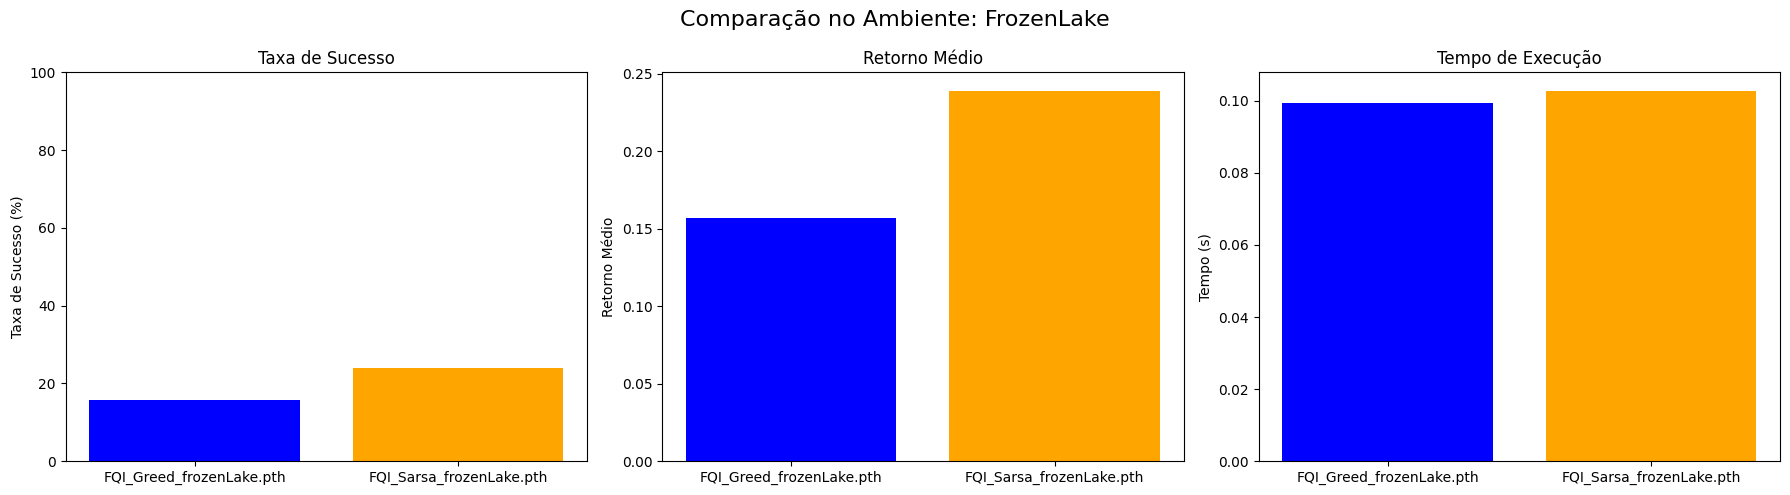

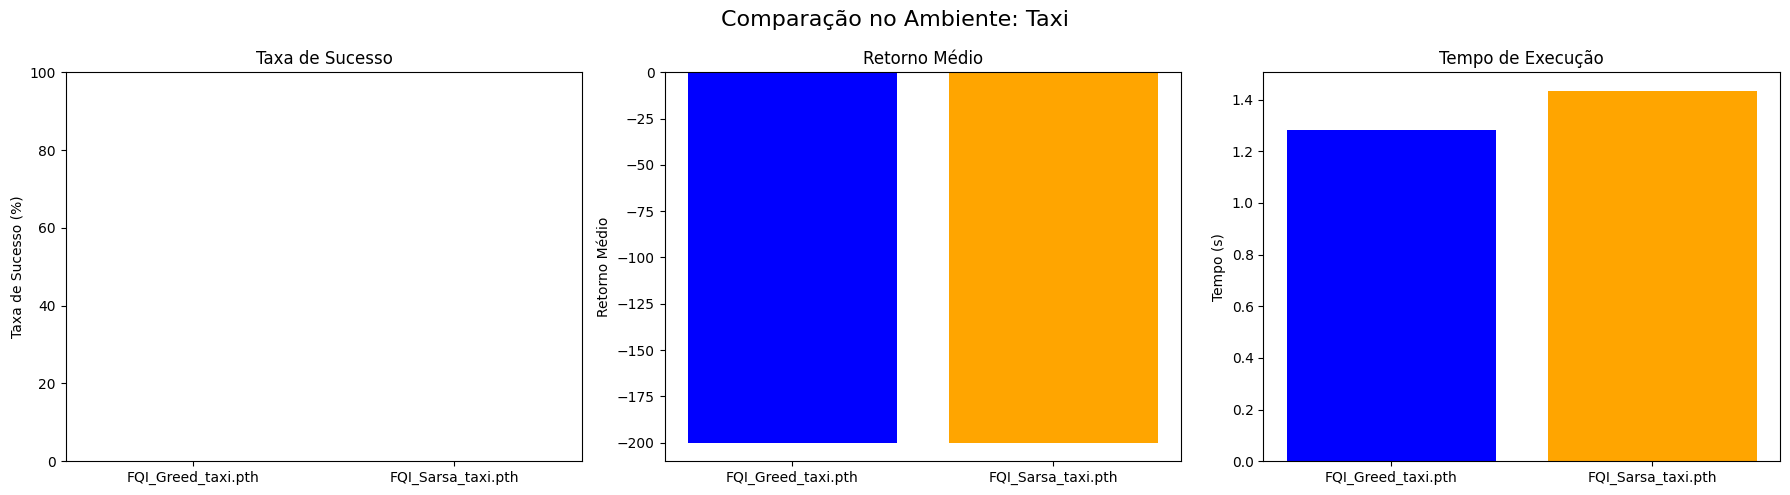

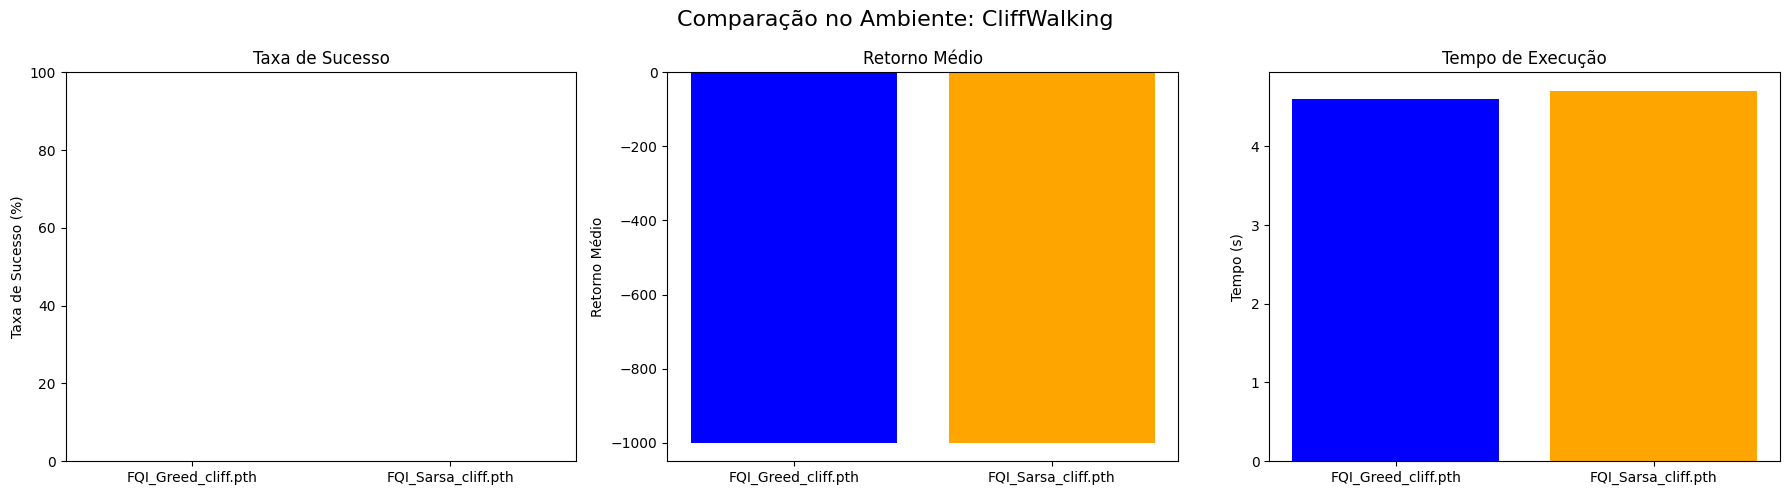

In [55]:
# Comparação Gráfica por Ambiente
for env_name, env_results in results.items():
    labels = list(env_results.keys())
    success_rates = [metrics["success_rate"] for metrics in env_results.values()]
    mean_returns = [metrics["mean_return"] for metrics in env_results.values()]
    execution_times = [metrics["eval_time"] for metrics in env_results.values()]

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"Comparação no Ambiente: {env_name}", fontsize=16)

    # Gráfico da Taxa de Sucesso
    plt.subplot(1, 3, 1)
    plt.bar(labels, success_rates, color=['blue', 'orange'])
    plt.title("Taxa de Sucesso")
    plt.ylabel("Taxa de Sucesso (%)")
    plt.ylim(0, 100)

    # Gráfico do Retorno Médio
    plt.subplot(1, 3, 2)
    plt.bar(labels, mean_returns, color=['blue', 'orange'])
    plt.title("Retorno Médio")
    plt.ylabel("Retorno Médio")

    # Gráfico do Tempo de Execução
    plt.subplot(1, 3, 3)
    plt.bar(labels, execution_times, color=['blue', 'orange'])
    plt.title("Tempo de Execução")
    plt.ylabel("Tempo (s)")

    plt.tight_layout()
    plt.show()